

# Question 3

Create a function that returns Prepayment Curves ("CPR") for the portfolio. 


- SMM: Sum(Balance@T that enters into Prepayment at time T+1) / Sum(Balance@T that has not Defaulted or Prepaid at time T)
- CPR: 1 - (1 - SMM)^12

The function should by default return CPR as a pandas series with an index of `seasoning` for the whole portfolio.  

However, your function should be able to take a list of`pivots' which are a list of column names, whereby the function will then return a dataframe with each column being the CPR for that unique value of pivot.

In [6]:
from portfolio_model import Loans_Portfolio

import pandas as pd
import datetime
import numpy as np

import matplotlib.pyplot as plt

pd.options.display.float_format = "{:,.2f}".format
pd.options.mode.copy_on_write = True

mystyle = '../style/pastel-light.mplstyle'
plt.style.use(mystyle)
%config InlineBackend.figure_format='retina'

In [1]:
cob = datetime.date(2022, 12, 31)  # 31/12/2022
ss_path = '../data/2024_Strat_Casestudy.xlsx'

In [2]:
portfolio = Loans_Portfolio(cob_date=cob, data_path=ss_path)

In [3]:
portfolio.create_enriched_data_portfolio()
df = portfolio.enriched_data

In [4]:
df

,loan_id,level_1,Balance,Payment_Due,Payment_Made,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,...,recovery_in_month,recovery_cumsum,is_recovery_payment,time_to_reversion,is_post_seller_purchsae_date,postdefault_recoveries,prepayment_date,date_of_default,exposure_at_default,recovery_percent
0,1,2020-12-31,"150,876.00",NaN,0.00,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-24,False,0.00,2021-08-31,NaT,NaN,NaN
1,1,2021-01-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-23,True,0.00,2021-08-31,NaT,NaN,NaN
2,1,2021-02-28,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-22,True,0.00,2021-08-31,NaT,NaN,NaN
3,1,2021-03-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-21,True,0.00,2021-08-31,NaT,NaN,NaN
4,1,2021-04-30,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-20,True,0.00,2021-08-31,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42606,1630,2022-08-31,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,0.00,0.00,False,-21,True,0.00,NaT,NaT,NaN,NaN
42607,1630,2022-09-30,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,0.00,0.00,False,-20,True,0.00,NaT,NaT,NaN,NaN
42608,1630,2022-10-31,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,0.00,0.00,False,-19,True,0.00,NaT,NaT,NaN,NaN
42609,1630,2022-11-30,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,0.00,0.00,False,-18,True,0.00,NaT,NaT,NaN,NaN


In [5]:
T = 4
pivot = 'product'
df[df.seasoning == T][['loan_id','level_1', 'prepayment_date', 'date_of_default', 'defaulted', 'current_balance', pivot]]

,loan_id,level_1,prepayment_date,date_of_default,defaulted,current_balance,product
4,1,2021-04-30,2021-08-31,NaT,0,"149,876.16",1
29,2,2020-11-30,NaT,NaT,0,"102,891.31",1
59,3,2018-06-30,2022-07-31,2022-04-30,0,"88,437.82",1
118,4,2017-08-31,NaT,NaT,0,"122,024.96",1
187,5,2021-10-31,NaT,NaT,0,"138,729.22",1
...,...,...,...,...,...,...,...
42452,1626,2018-03-31,NaT,NaT,0,"233,384.03",2
42514,1627,2022-01-31,NaT,NaT,0,"223,672.49",2
42530,1628,2020-08-31,NaT,NaT,0,"157,341.48",2
42563,1629,2019-09-30,NaT,NaT,0,"240,490.95",2


In [7]:
def calculate_smm(dta):

    if dta.empty:
        return np.nan

    numerator = 0.
    denominator = 0.

    for row in dta.itertuples():
        if not (pd.isnull(row.prepayment_date)):
            # print(row.prepayment_date)
            x = row.prepayment_date  
            y = row.level_1
            months = (x.to_period('M') - y.to_period('M')).n
            
            if months == 1:
                numerator += row.current_balance
        if row.defaulted == 0:
            if(pd.isnull(row.prepayment_date) or row.level_1 < row.prepayment_date):
                denominator+= row.current_balance
                
    return numerator/denominator

In [18]:
seasonings

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [39]:
df.time_to_reversion.unique()

array([-24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
       -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59])

In [36]:
seasonings = df.seasoning.unique()

pivots = ['product']


results = []
for p in df[pivot].unique():
        sub_data = df[df[pivot] == p]
        smms = []
        cprs = []

        for T in seasonings:
                dta = sub_data[sub_data.seasoning == T]
                smm = calculate_smm(dta)
                smms.append(smm)
                cpr = 1. - ((1. - smm)**12)
                cprs.append(cpr)
        result = pd.DataFrame(
            {'seasonings': seasonings, f'smm_{pivot}_{p}': smms, f'cpr_{pivot}_{p}': cprs})
        results.append(result)

all_results = pd.concat(results, axis=1)

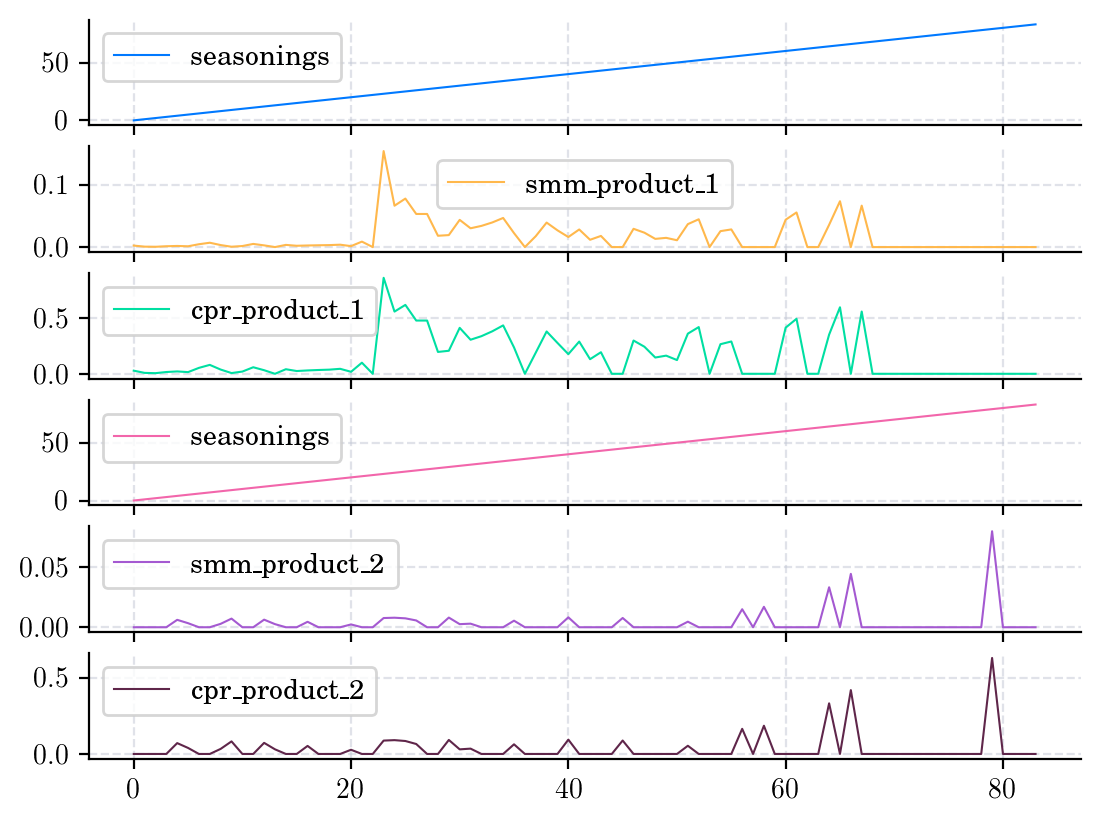

In [38]:
all_results.plot(subplots=True)
plt.show()

In [55]:
df.head()

,loan_id,level_1,Balance,Payment_Due,Payment_Made,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,...,recovery_in_month,recovery_cumsum,is_recovery_payment,time_to_reversion,is_post_seller_purchsae_date,postdefault_recoveries,prepayment_date,date_of_default,exposure_at_default,recovery_percent
0,1,2020-12-31,"150,876.00",NaN,0.00,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-24,False,0.00,2021-08-31,NaT,NaN,NaN
1,1,2021-01-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-23,True,0.00,2021-08-31,NaT,NaN,NaN
2,1,2021-02-28,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-22,True,0.00,2021-08-31,NaT,NaN,NaN
3,1,2021-03-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-21,True,0.00,2021-08-31,NaT,NaN,NaN
4,1,2021-04-30,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,0.00,0.00,False,-20,True,0.00,2021-08-31,NaT,NaN,NaN


In [84]:
index = 'seasoning'
index = 'time_to_reversion'
index = 'origination_date'
pivots = ['product']

index_values = df[index].unique()
unique_values = []
for pivot in pivots:
    unique_values.append(df[pivot].unique())

for p, values in zip(pivots, unique_values):
    results = []
    for v in values:
        
        sub_data = df[df[p] == v]
        smms = []
        cprs = []
        for T in index_values:
            dta = sub_data[sub_data[index] == T]
            smm = calculate_smm(dta)
            smms.append(smm)
            cpr = 1. - ((1. - smm)**12)
            cprs.append(cpr)
        result = pd.DataFrame(
            {f'smm_{p}_{v}': smms, f'cpr_{p}_{v}': cprs}, index=index_values)
        results.append(result)

all_results = pd.concat(results, axis=1)

In [85]:
all_results.head()

,smm_product_1,cpr_product_1,smm_product_2,cpr_product_2
2020-12-31,0.01,0.12,0.00,0.00
2020-07-31,0.01,0.14,0.00,0.00
2018-02-28,0.02,0.20,0.00,0.04
2017-04-30,0.00,0.04,0.00,0.00
2021-06-30,0.01,0.07,0.00,0.00


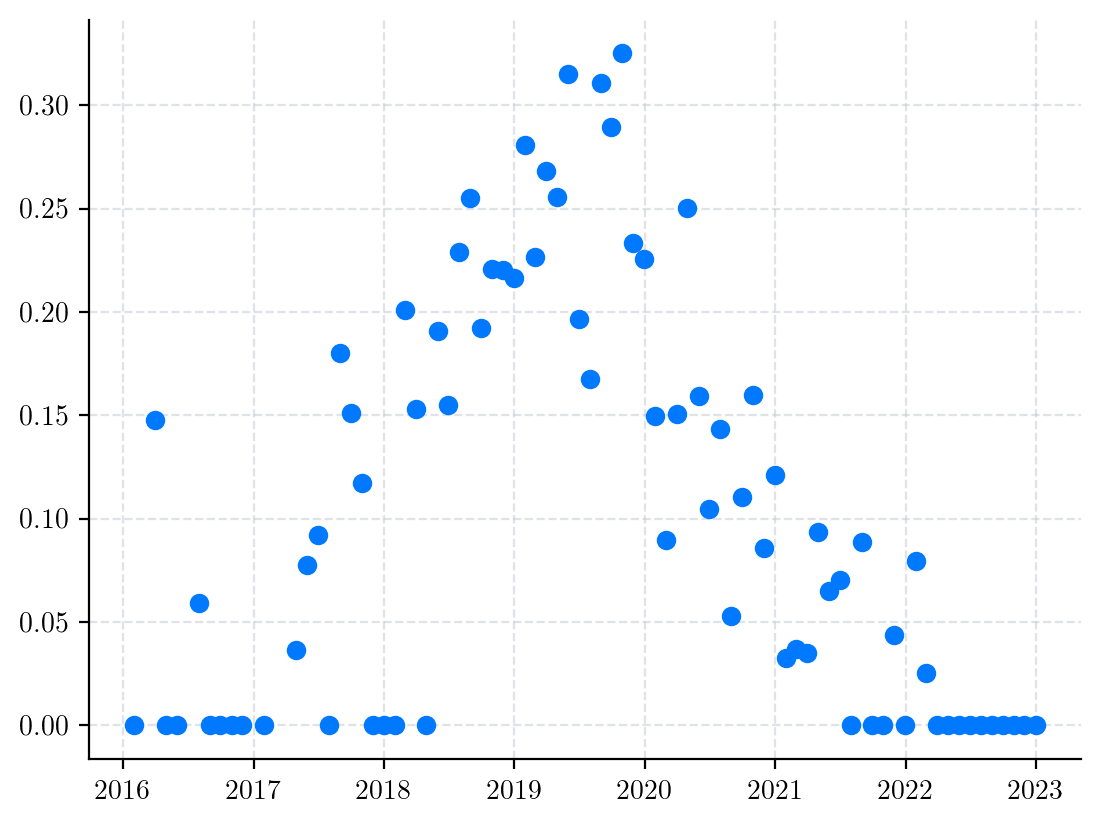

In [91]:
plt.scatter(all_results.index, all_results.cpr_product_1)
plt.show()

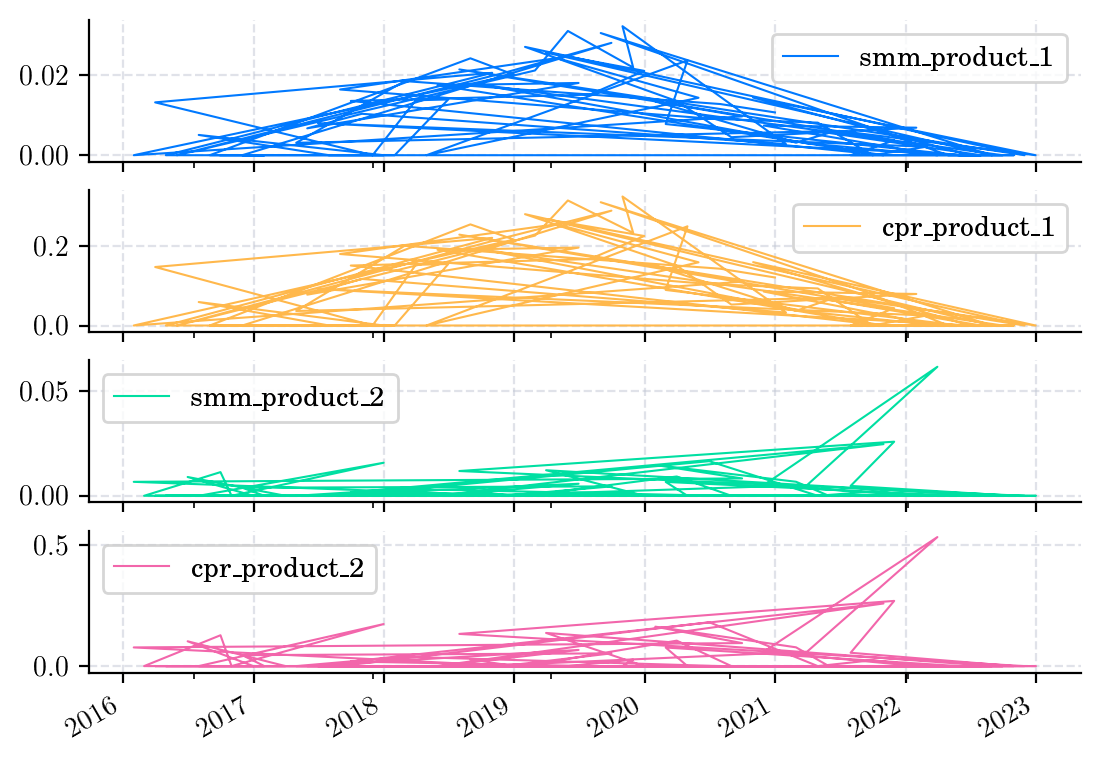

In [89]:
all_results.plot( subplots=True)
plt.show()

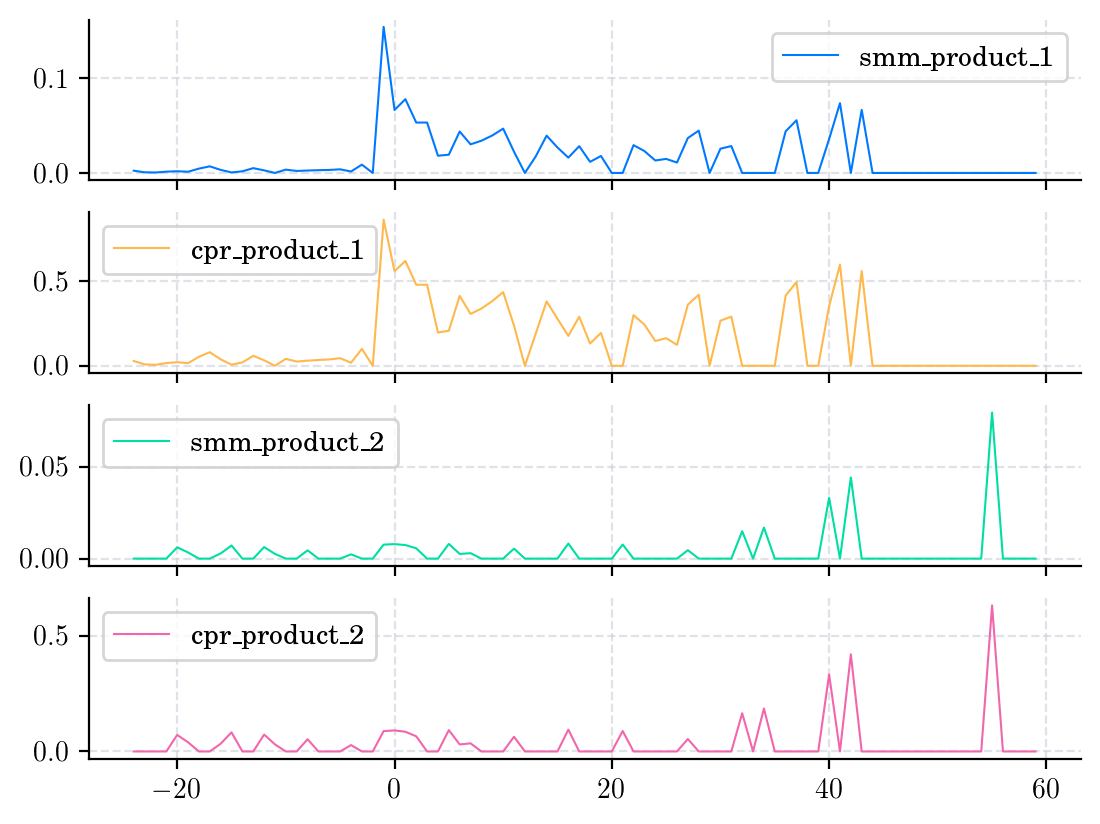

In [80]:
all_results.plot(subplots=True)
plt.show()